In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
from datetime import datetime
import itertools
from scipy.stats import linregress
from sklearn import linear_model
#from pysal.explore import esda
#from pysal.lib import weights

In [2]:
file = r"C:\Users\PcLaptop\Dropbox (Politecnico Di Torino Studenti)\Untitled Folder\temp-prec-conf.csv"
df = pd.read_csv(file)

In [3]:
reg=[]
for admin in df['admin1'].unique():
    a = df[df['admin1']==admin].reset_index(drop=True)
    reg.append(a)

In [23]:
for i in range(18):
    reg[i]['time_x'] = pd.to_datetime(reg[i]['time_x'])
    reg[i].set_index('time_x', inplace=True)
    reg[i]['avg tmx 3months'] = reg[i]['tmx'].rolling(window=3).mean()
    reg[i]['avg pre 3months'] = reg[i]['pre'].rolling(window=3).mean()
    
    reg[i]['std tmx 3months'] = reg[i]['tmx'].rolling(window=3).std()
    reg[i]['std pre 3months'] = reg[i]['pre'].rolling(window=3).std()
    
    reg[i]['difference']= (reg[i]['tmx']-reg[i]['avg tmx 3months'])/reg[i]['std tmx 3months']
    reg[i]['diff_p']= (reg[i]['pre']-reg[i]['avg pre 3months'])/reg[i]['std pre 3months']
    
    reg[i]['TA'] = (reg[i]['difference'].shift(2) + reg[i]['difference'].shift(1) + reg[i]['difference'])/3
    reg[i]['PA'] = (reg[i]['diff_p'].shift(2) + reg[i]['diff_p'].shift(1) + reg[i]['diff_p'])/3
    #reg[i]['PA'] = reg[i]['pre'].rolling(window=3, center=True).std()
    #reg[i] = reg[i].reindex(columns=['admin1','conflicts','time_y','tmx','TA','pre','PA'])
    reg[i] = reg[i].reset_index()

In [24]:
reg[2]

,time_x,admin1,conflicts,time_y,tmx,TA,pre,PA,avg tmx 3months,avg pre 3months,std tmx 3months,std pre 3months,difference,diff_p
0,1997-02-15,Banadir,0.0,1997-02-28 00:00:00,33.170001,NaN,1.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-03-16,Banadir,0.0,1997-03-31 00:00:00,34.145000,NaN,20.380001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1997-04-16,Banadir,2.0,1997-04-30 00:00:00,33.730002,NaN,94.355010,NaN,33.681668,38.661670,0.489293,49.171133,0.098784,1.132643
3,1997-05-16,Banadir,0.0,0,32.590000,NaN,50.079998,NaN,33.488334,54.938336,0.805176,37.226041,-1.115699,-0.130509
4,1997-06-16,Banadir,0.0,1997-06-30 00:00:00,31.170001,-0.683771,24.965000,0.035165,32.496668,56.466669,1.282550,35.133112,-1.034398,-0.896638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,2009-08-16,Banadir,61.0,2009-08-31 00:00:00,31.000000,-0.696692,20.710000,-0.975467,31.068333,31.893335,0.560631,9.849077,-0.121886,-1.135470
151,2009-09-16,Banadir,18.0,2009-09-30 00:00:00,32.195002,0.014262,10.285000,-0.905624,31.246667,22.230001,0.852208,12.773013,1.112796,-0.935175
152,2009-10-16,Banadir,40.0,2009-10-31 00:00:00,31.925001,0.446431,66.999998,-0.311096,31.706668,32.664999,0.626705,30.188396,0.348383,1.137357
153,2009-11-16,Banadir,31.0,2009-11-30 00:00:00,32.350004,0.786694,74.905005,0.296008,32.156669,50.730001,0.215079,35.248700,0.898904,0.685841


In [50]:
start_month = 8
window_size = 142
shift_t = -4
shift_p = -4

r=2
X = pd.DataFrame({'TA':reg[r]['TA'][start_month + shift_t : start_month + shift_t + window_size].reset_index(drop=True),
                  'PA':reg[r]['PA'][start_month + shift_p : start_month + shift_p + window_size].reset_index(drop=True) })

y = reg[r]['conflicts'][start_month : start_month + window_size]

regr = linear_model.LinearRegression()
regr.fit(X, y)
print("Intercept: ", regr.intercept_)
print("Coefficients:",list(zip(X, regr.coef_)))
#display adjusted R-squared
1 - (1-regr.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

Intercept:  29.744474865113165
Coefficients: [('TA', 12.139392722761604), ('PA', -4.485624633105196)]


0.01954428043300538

In [48]:
# Assuming you have a list of vector pairs
slopes=[]
rvalues=[]

r=2
start_month =12
window_size = 142
r2=[]
c_t=[]
c_p=[]

shifts=[-8,-7,-6,-5,-4,-3,-2,-1,0]
for shift in shifts:

    X = pd.DataFrame({'TA':reg[r]['TA'][start_month + shift : start_month + shift + window_size].reset_index(drop=True),
                      'PA':reg[r]['PA'][start_month + shift : start_month + shift + window_size].reset_index(drop=True) })
    y = reg[r]['conflicts'][start_month : start_month + window_size]

    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    c_t.append(regr.coef_[0])
    c_p.append(regr.coef_[1])
    r2.append(1 - (1-regr.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)) 

In [ ]:
# Assuming you have a list of vector pairs
slopes=[]
rvalues=[]

r=2
start_month =12
window_size = 142
r2=[]
c_t=[]
c_p=[]

shifts=[-8,-7,-6,-5,-4,-3,-2,-1,0]
for shift in shifts:

    X = pd.DataFrame({'TA':reg[r]['TA'][start_month + shift : start_month + shift + window_size].reset_index(drop=True),
                      'PA':reg[r]['PA'][start_month + shift : start_month + shift + window_size].reset_index(drop=True) })
    y = reg[r]['conflicts'][start_month : start_month + window_size]

    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    c_t.append(regr.coef_[0])
    c_p.append(regr.coef_[1])
    r2.append(1 - (1-regr.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)) 

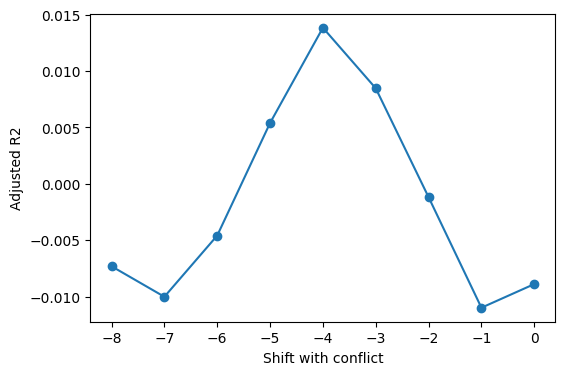

In [49]:
f, ax = plt.subplots(figsize=(6, 4))
plt.plot(shifts,r2,marker="o")
#ax.set(title="Adjusted R2")
plt.xlabel('Shift with conflict')
plt.ylabel('Adjusted R2')
plt.show()

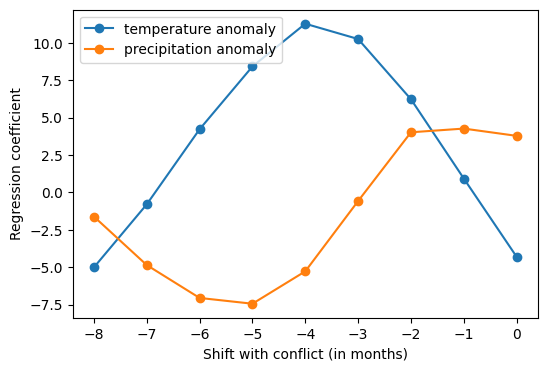

In [39]:
f, ax = plt.subplots(figsize=(6, 4))
plt.plot(shifts,c_t,marker="o",label='temperature anomaly')
plt.plot(shifts,c_p,marker="o",label='precipitation anomaly')
#ax.set(title="Adjusted R2")
plt.xlabel('Shift with conflict (in months)')
plt.ylabel('Regression coefficient')
plt.legend(loc='upper left')
plt.show()